<a href="https://colab.research.google.com/github/krishyadav007/CBIR-/blob/main/CBIR_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1
		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim, name="encoded")(x)
		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		x = Dense(np.prod(volumeSize[1:]))(latent)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid", name="decoded")(x)
		# construct our autoencoder model
		autoencoder = Model(inputs, outputs, name="autoencoder")
		# return the autoencoder model
		return autoencoder

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
import conv
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None
	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")
		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])
		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output
		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])
	# return the output images
	return outputs

def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None
	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")
		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])
		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output
		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])
	# return the output images
	return outputs

# construct the argument parse and parse the arguments

# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
autoencoder = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(r"/content/drive/MyDrive/AiM/recon_vis.png", vis)
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(r"/content/drive/MyDrive/AiM/plot.png")
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(r"/content/drive/MyDrive/AiM/test.h5", save_format="h5")

[INFO] loading MNIST dataset...
11493376/11490434 [==============================] - 0s 0us/step
[INFO] building autoencoder...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1875/1875 [==============================] - 39s 4ms/step - loss: 0.0183 - val_loss: 0.0110
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0074 - val_loss: 0.0077
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.00

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
import numpy as np
import argparse
import pickle
## construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to trained autoencoder")
#ap.add_argument("-i", "--index", type=str, required=True,
#	help="path to output features index file")
#args = vars(ap.parse_args())

# load the MNIST dataset
print("[INFO] loading MNIST training split...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the training split, then
# scale the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
trainX = trainX.astype("float32") / 255.0



# load our autoencoder from disk
print("[INFO] loading autoencoder model...")
autoencoder = load_model("/content/drive/MyDrive/AiM/test.h5")
# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)
# quantify the contents of our input images using the encoder
print("[INFO] encoding images...")
features = encoder.predict(trainX)





# construct a dictionary that maps the index of the MNIST training
# image to its corresponding latent-space representation
indexes = list(range(0, trainX.shape[0]))
data = {"indexes": indexes, "features": features}
# write the data dictionary to disk
print("[INFO] saving index...")
f = open("/content/drive/MyDrive/AiM/index.pickle", "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] loading MNIST training split...
[INFO] loading autoencoder model...
[INFO] encoding images...
[INFO] saving index...


[INFO] loading MNIST dataset...
[INFO] loading autoencoder and index...
[INFO] encoding testing images...


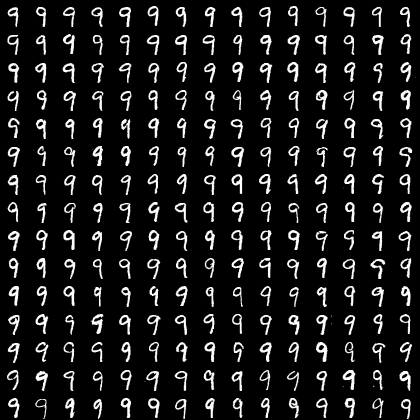

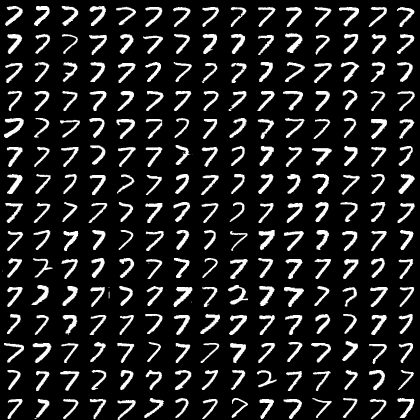

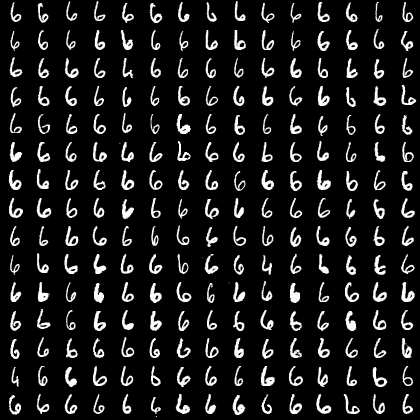

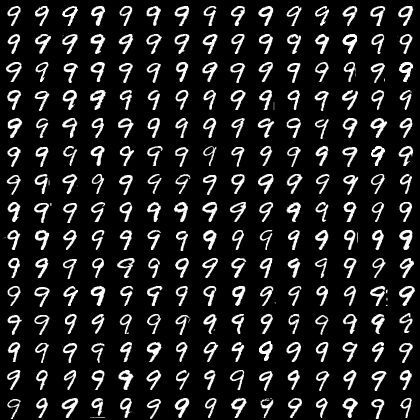

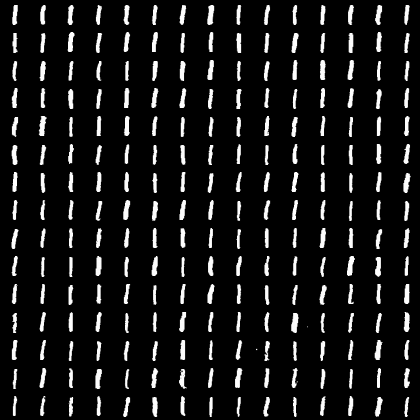

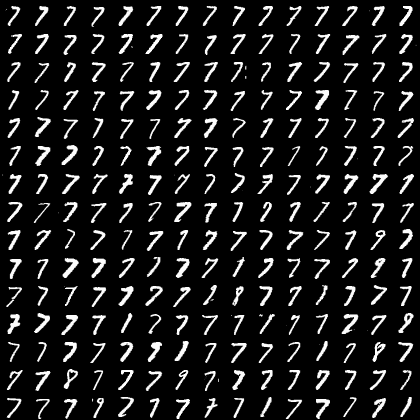

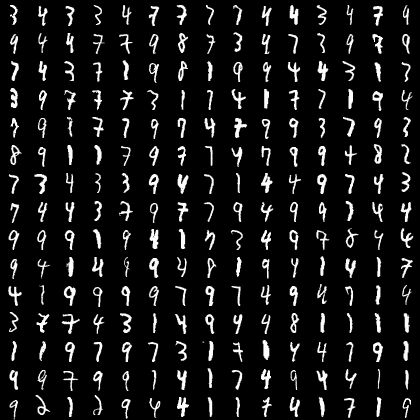

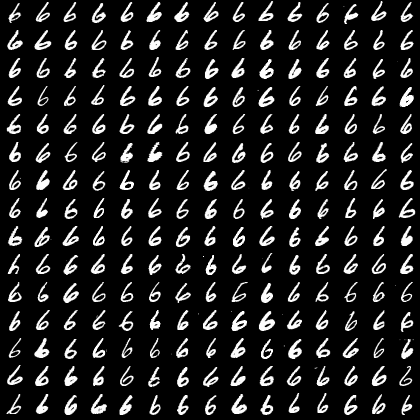

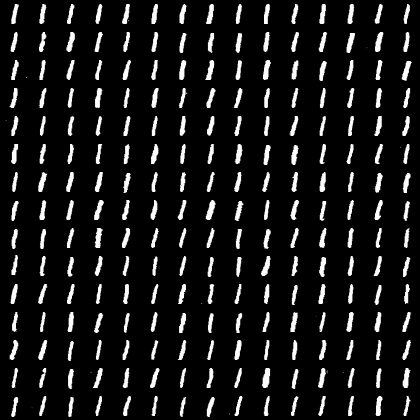

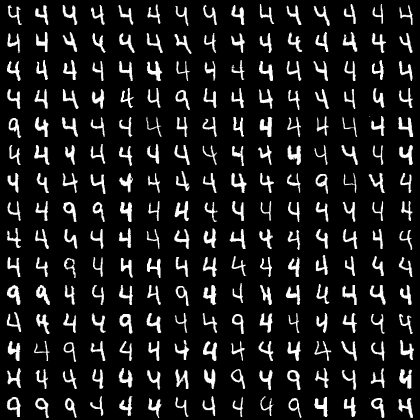

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from imutils import build_montages
import numpy as np
import argparse
import pickle
import cv2
from google.colab.patches import cv2_imshow


def euclidean(a, b):
	# compute and return the euclidean distance between two vectors
	return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, maxResults=64):
	# initialize our list of results
	results = []
	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features
		# and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the
		# computed distance and the index of the image
		d = euclidean(queryFeatures, index["features"][i])
		results.append((d, i))
	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]
	# return the list of results
	return results

## construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to trained autoencoder")
#ap.add_argument("-i", "--index", type=str, required=True,
#	help="path to features index file")
#ap.add_argument("-s", "--sample", type=int, default=10,
#	help="# of testing queries to perform")
#args = vars(ap.parse_args())

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# load the autoencoder model and index from disk
print("[INFO] loading autoencoder and index...")
autoencoder = load_model("/content/drive/MyDrive/AiM/test.h5")
index = pickle.loads(open("/content/drive/MyDrive/AiM/index.pickle", "rb").read())
# create the encoder model which consists of *just* the encoder
# portion of the autoencoder
encoder = Model(inputs=autoencoder.input,
	outputs=autoencoder.get_layer("encoded").output)
# quantify the contents of our input testing images using the encoder
print("[INFO] encoding testing images...")
features = encoder.predict(testX)

# randomly sample a set of testing query image indexes
queryIdxs = list(range(0, testX.shape[0]))
queryIdxs = np.random.choice(queryIdxs, size=10,
	replace=False)
# loop over the testing indexes
for i in queryIdxs:
	# take the features for the current image, find all similar
	# images in our dataset, and then initialize our list of result
	# images
	queryFeatures = features[i]
	results = perform_search(queryFeatures, index, maxResults=225)
	images = []
	# loop over the results
	for (d, j) in results:
		# grab the result image, convert it back to the range
		# [0, 255], and then update the images list
		image = (trainX[j] * 255).astype("uint8")
		image = np.dstack([image] * 3)
		images.append(image)
	# display the query image
	query = (testX[i] * 255).astype("uint8")
	cv2_imshow(query)
	# build a montage from the results and display it
	montage = build_montages(images, (28, 28), (15, 15))[0]
	cv2_imshow(montage)
	cv2.waitKey(0)